In [1]:
import pandas as pd

# Assumes the file is in the same folder as the notebook
business_df = pd.read_json('yelp_academic_dataset_business.json', lines=True)
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [3]:
#Filter Only Restaurant Businesses
restaurant_df = business_df[
    business_df['categories'].fillna('').str.contains('Restaurant', case=False)
]
restaurant_df.shape

(52286, 14)

In [6]:
# Remove columns that can't be stored in SQLite
restaurant_clean = restaurant_df.drop(columns=['attributes', 'hours'])

# Save cleaned data to SQLite
import sqlite3
conn = sqlite3.connect('yelp.db')
restaurant_clean.to_sql('restaurant', conn, index=False, if_exists='replace')

52286

In [10]:
#Top 10 Cities with the Most Restaurants
import pandas as pd

query = """
SELECT city, COUNT(*) AS restaurant_count
FROM restaurant
GROUP BY city
ORDER BY restaurant_count DESC
LIMIT 10
"""

top_cities = pd.read_sql_query(query, conn)
top_cities

,city,restaurant_count
0,Philadelphia,5854
1,Tampa,2961
2,Indianapolis,2862
3,Nashville,2503
4,Tucson,2470
5,New Orleans,2260
6,Edmonton,2166
7,Saint Louis,1791
8,Reno,1288
9,Boise,849


In [11]:
#Average Star Rating by City (Top 10 by Business Count)
query = """
SELECT city, 
       COUNT(*) AS num_restaurants,
       ROUND(AVG(stars), 2) AS avg_rating
FROM restaurant
GROUP BY city
HAVING num_restaurants > 100
ORDER BY avg_rating DESC
LIMIT 10
"""

avg_rating_city = pd.read_sql_query(query, conn)
avg_rating_city

,city,num_restaurants,avg_rating
0,Santa Barbara,767,3.83
1,Dunedin,188,3.82
2,Tarpon Springs,151,3.75
3,New Orleans,2260,3.74
4,Ardmore,126,3.71
5,Malvern,113,3.68
6,St. Louis,543,3.66
7,Palm Harbor,207,3.66
8,St. Petersburg,404,3.65
9,St Louis,149,3.65


In [12]:
# Most Common Restaurant Categories
# Extract and count category frequencies
from collections import Counter

all_categories = restaurant_clean['categories'].dropna().str.split(', ')
flat_list = [cat for sublist in all_categories for cat in sublist]
cat_counts = pd.DataFrame(Counter(flat_list).most_common(15), columns=['Category', 'Count'])
cat_counts

,Category,Count
0,Restaurants,52268
1,Food,15477
2,Nightlife,8723
3,Sandwiches,8366
4,Bars,8337
5,American (Traditional),8139
6,Pizza,7093
7,Fast Food,6472
8,Breakfast & Brunch,6239
9,American (New),6097


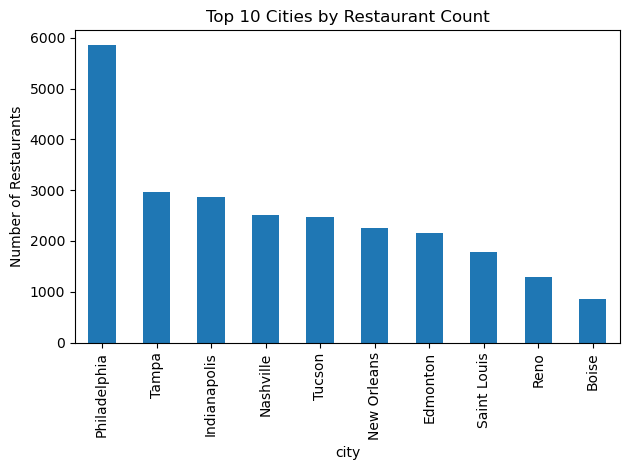

In [13]:
#Bar Chart: Top Restaurant Cities
import matplotlib.pyplot as plt

top_cities.plot(kind='bar', x='city', y='restaurant_count', legend=False, title='Top 10 Cities by Restaurant Count')
plt.ylabel("Number of Restaurants")
plt.tight_layout()
plt.show()

In [16]:
# Total and Average Number of Reviews for 4-Star vs. 5-Star
query = """
SELECT 
    stars,
    COUNT(*) AS num_businesses,
    SUM(review_count) AS total_reviews,
    ROUND(AVG(review_count), 2) AS avg_reviews_per_business
FROM restaurant
WHERE stars IN (4.0, 5.0)
GROUP BY stars
ORDER BY stars DESC
"""

stars_comparison = pd.read_sql_query(query, conn)
stars_comparison

,stars,num_businesses,total_reviews,avg_reviews_per_business
0,5.0,1554,51069,32.86
1,4.0,13444,1772828,131.87


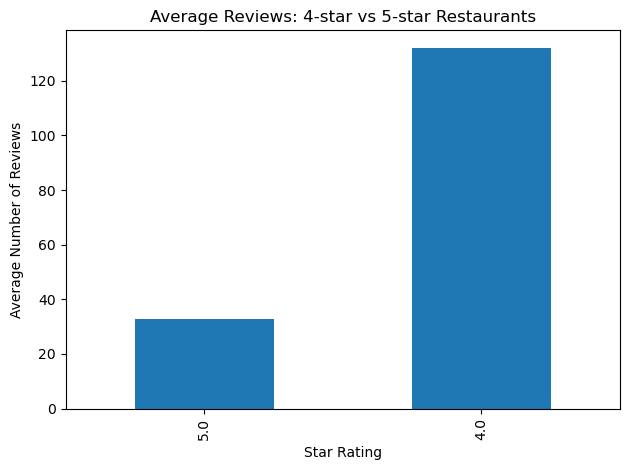

In [18]:
import matplotlib.pyplot as plt

stars_comparison.plot(kind='bar', x='stars', y='avg_reviews_per_business', legend=False, title='Average Reviews: 4-star vs 5-star Restaurants')
plt.ylabel("Average Number of Reviews")
plt.xlabel("Star Rating")
plt.tight_layout()
plt.show()